In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [3]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [4]:
!ls drive/MyDrive/labeled_images/train

food  interior


In [5]:
train_data_dir = 'drive/MyDrive/labeled_images/train'
test_data_dir = 'drive/MyDrive/labeled_images/test'

class_subset = ['food', 'interior']

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1276 images belonging to 2 classes.
Found 224 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


In [6]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [7]:
!pip3 install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [9]:
input_shape = (224, 224, 3)
n_classes=2
n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

In [10]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


58889256/58889256 [==============================] - 0s 0us/step


In [19]:
vgg_model_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

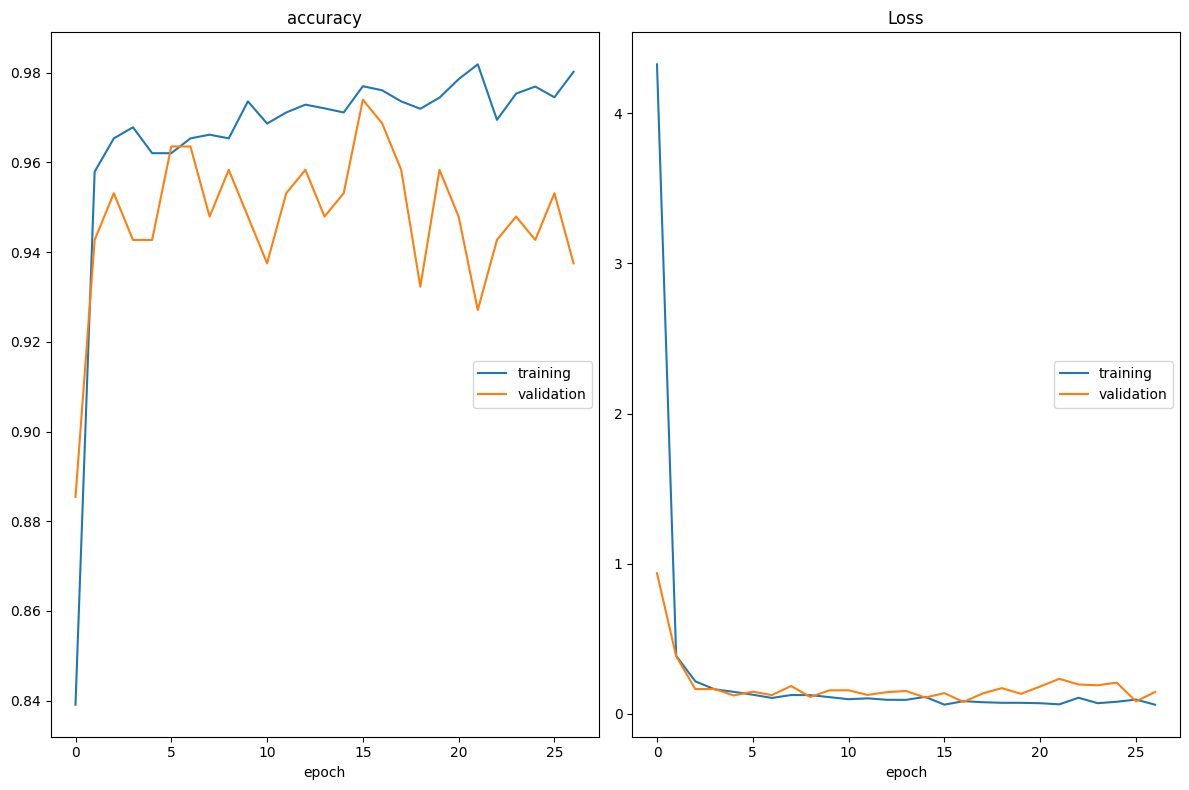

accuracy
	training         	 (min:    0.839, max:    0.982, cur:    0.980)
	validation       	 (min:    0.885, max:    0.974, cur:    0.938)
Loss
	training         	 (min:    0.061, max:    4.327, cur:    0.061)
	validation       	 (min:    0.080, max:    0.937, cur:    0.146)
19/19 [==============================] - 54s 3s/step - loss: 0.0612 - accuracy: 0.9802 - val_loss: 0.1457 - val_accuracy: 0.9375
CPU times: user 25min 4s, sys: 1min 3s, total: 26min 8s
Wall time: 35min 38s


In [11]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [12]:
# Generate predictions
vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

496/496 [==============================] - 125s 251ms/step


In [13]:
from sklearn.metrics import accuracy_score

true_classes = testgen.classes
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 97.58%


# Plot prediction

In [26]:
import matplotlib.pyplot as plt
import math

def plt_images(img_filepaths, titles=[]):
    for idx, image_path in enumerate(img_filepaths):
        image = plt.imread(image_path)
        amount_of_cols = 5
        amount_of_rows = math.ceil(len(img_filepaths) / amount_of_cols) 
        plt.subplot(amount_of_rows, amount_of_cols,idx+1)
        plt.imshow(image)
        
        if titles:
            plt.title(titles[idx], fontsize=16)
        plt.axis('off')

In [27]:
DIRECTORY_FOOD = 'drive/MyDrive/labeled_images/test/food'
DIRECTORY_INTERIOR = 'drive/MyDrive/labeled_images/test/interior'


img_filepaths_food = [os.path.join(DIRECTORY_FOOD, filename) for filename in os.listdir(DIRECTORY_FOOD)]
img_filepaths_interior = [os.path.join(DIRECTORY_INTERIOR, filename) for filename in os.listdir(DIRECTORY_INTERIOR)]
img_filepaths = np.array(
    img_filepaths_food + img_filepaths_interior
)

len(img_filepaths)

496

In [28]:
import random

# randomly select sublist of size 20
random.seed(123)
idx_of_imgs_to_plot = random.sample(range(len(img_filepaths)), 20)

selcted_imgs = img_filepaths[idx_of_imgs_to_plot]

# selected_pred_class = np.array(vgg_pred_classes_ft)[idx_of_imgs_to_plot]
# selected_true_class = np.array(true_classes)[idx_of_imgs_to_plot]

selected_titles = [f'Pred={"interior" if vgg_pred_classes_ft[i] else "food"}/True={"interior" if true_classes[i] else "food"}' for i in idx_of_imgs_to_plot]

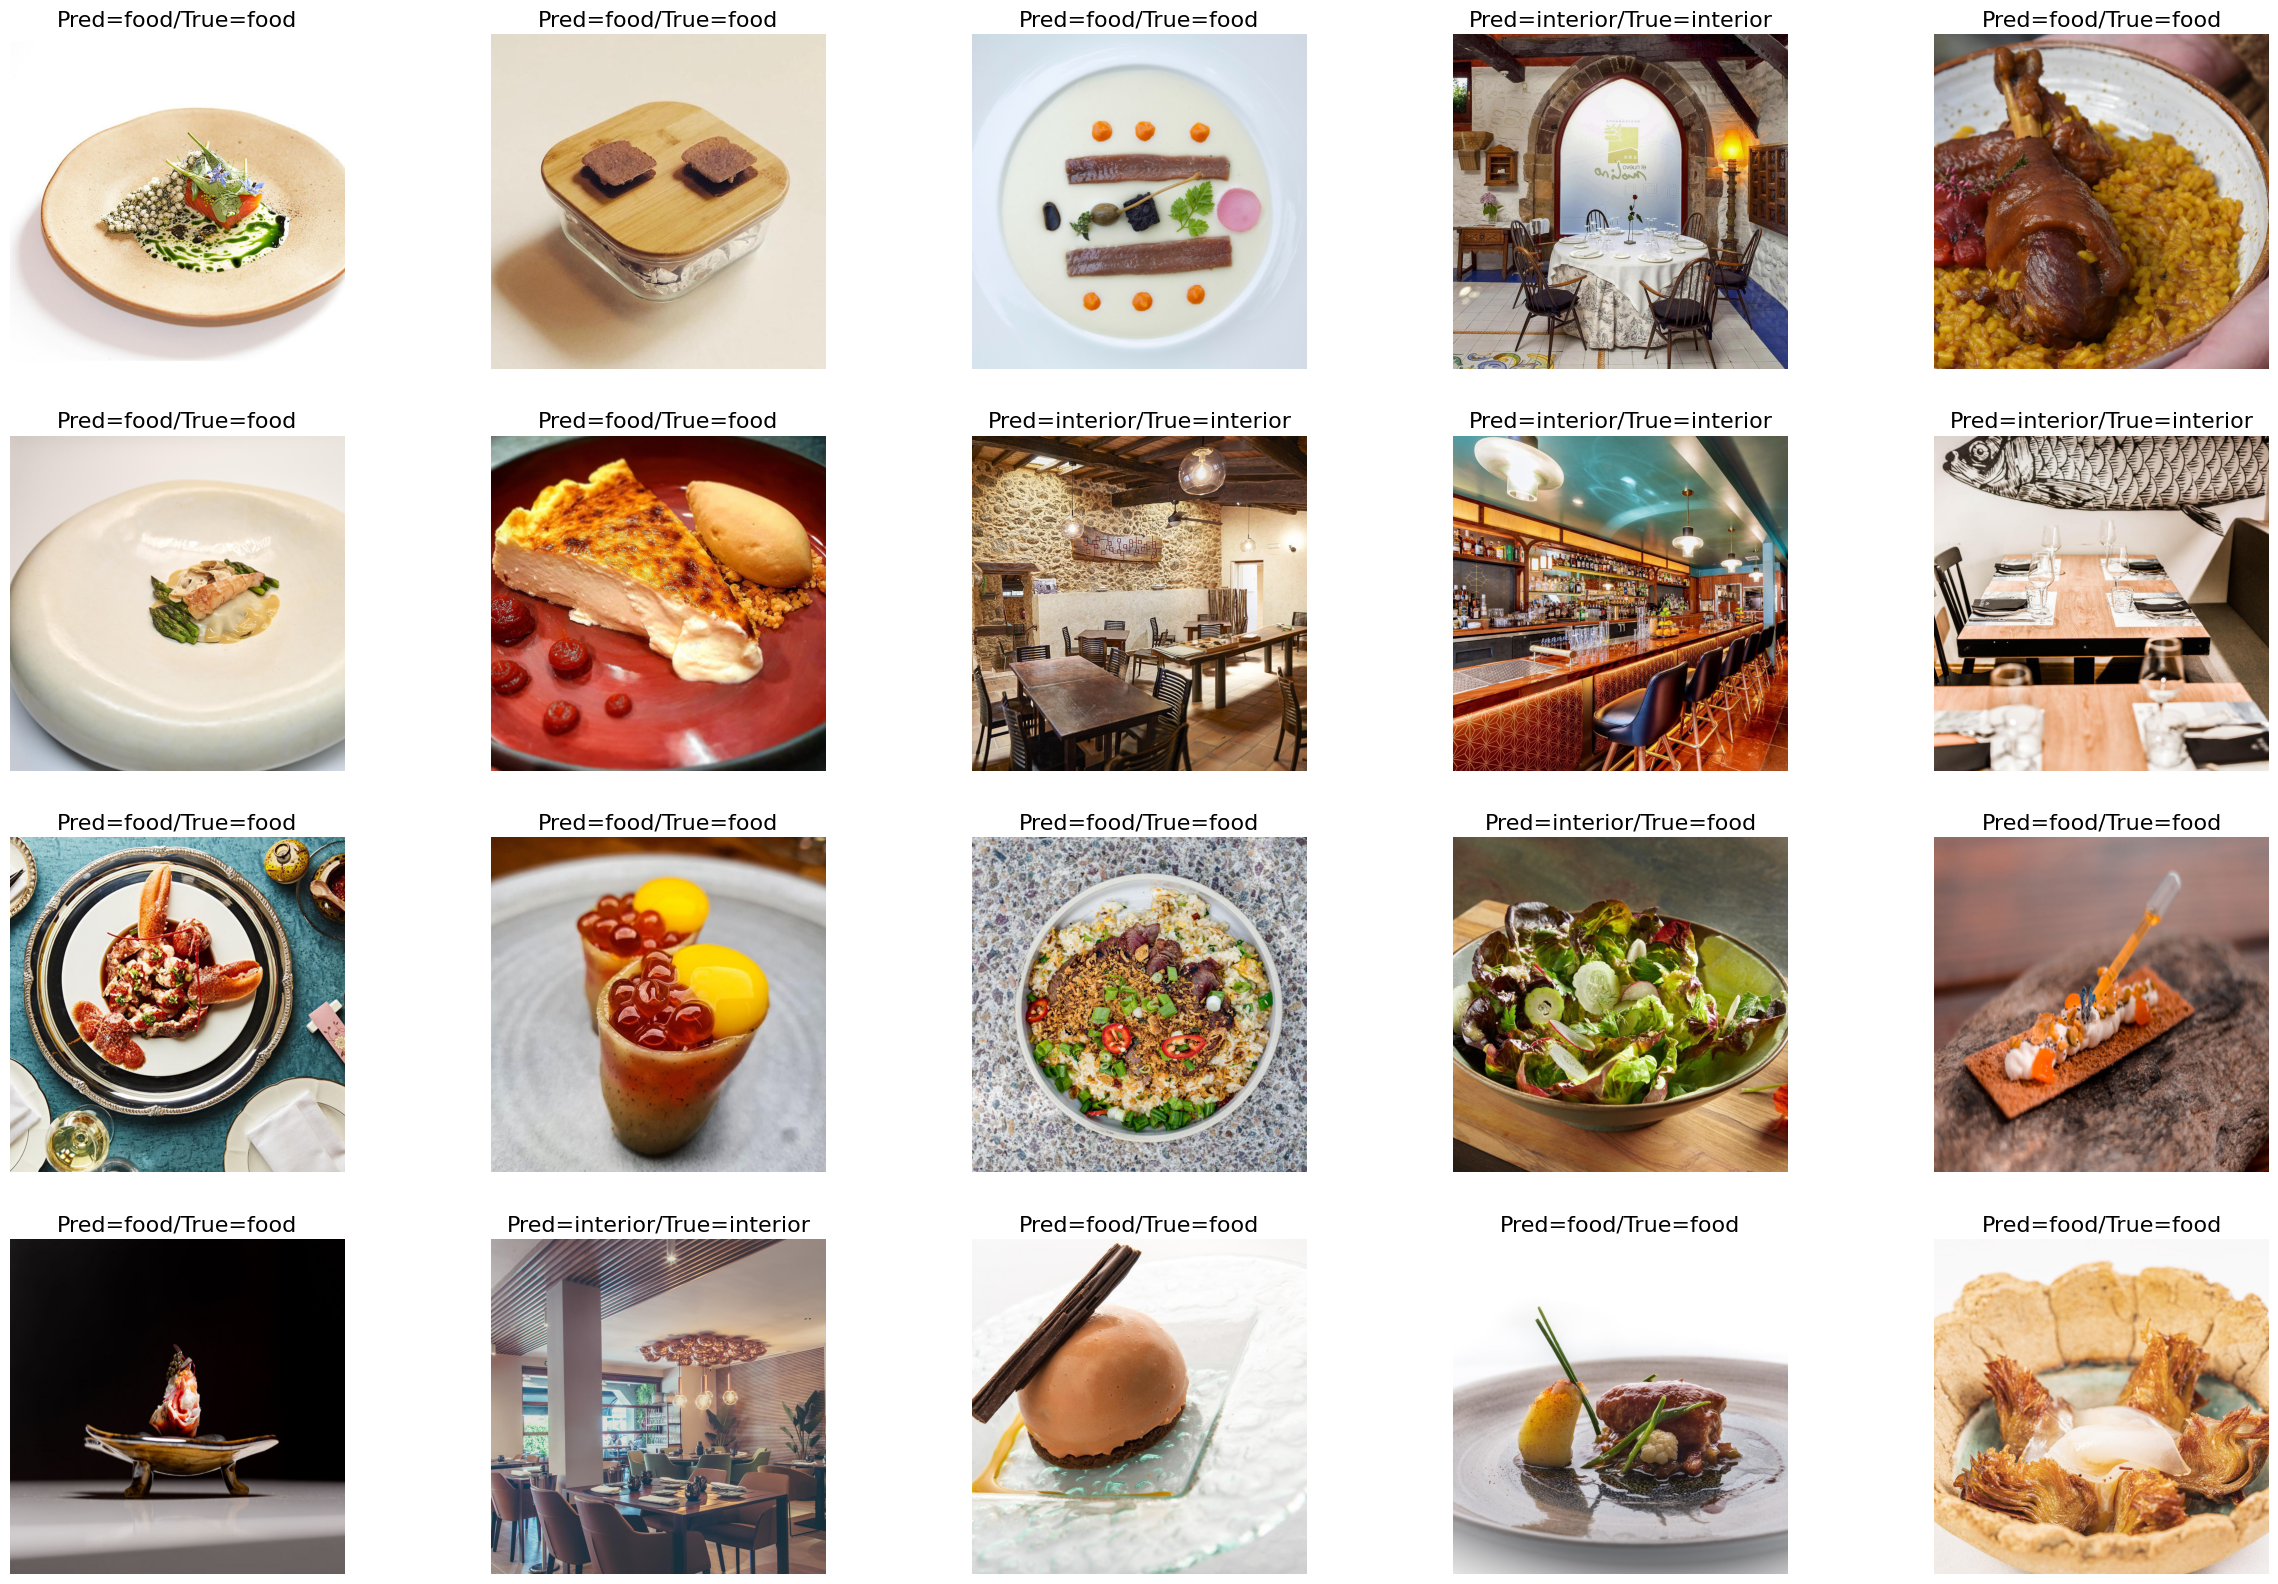

In [30]:
plt.figure(figsize=(30,20))

plt_images(selcted_imgs, selected_titles)

In [18]:
selected_titles

['Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=interior/True=interior',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=interior/True=interior',
 'Pred=interior/True=interior',
 'Pred=interior/True=interior',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=interior/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=interior/True=interior',
 'Pred=interior/True=interior',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=interior/True=interior',
 'Pred=food/True=interior',
 'Pred=interior/True=interior',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=interior/True=interior',
 'Pred=food/True=food',
 'Pred=interior/True=interior',
 'Pred=interior/True=interior',
 'Pred=interior/True=interior',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=food/True=food',
 'Pred=i